In [52]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Process qPCR data (32-cell and 64-cell stages)

In [2]:
df_Q = pd.read_csv('./scData/qPCR_original.csv', sep=',', index_col=0)

#### Read in data and do clustering for both 64-cell stage and 32-cell stage data
The assignment of ICM cells were done following the original publication.
[Guoji Guo, et al., Developmental Cell, 2010]

In [3]:
cname_Q = list( df_Q.index )
gname_Q = list( df_Q.columns.values )
for i in range(len(gname_Q)):
    if gname_Q[i] == 'Pou5f1':
        gname_Q[i] = 'Oct4'
mat_Q = np.asarray( df_Q.values, float )
mat_Q = 28.0 - mat_Q; mat_Q[np.where(mat_Q < 0)[0]] = 0.0;
endo_control = (0.5 * ( mat_Q[:,gname_Q.index("Actb")] + mat_Q[:,gname_Q.index("Gapdh")] )).reshape(-1,1)
mat_Q = mat_Q - endo_control
tmp_ind = np.array([i for i in range(len(gname_Q)) if not gname_Q[i] in ["Actb","Gapdh"]],int)
mat_Q = mat_Q[:,tmp_ind]

In [4]:
cind_Q_64C_all = []
for i in range(len(cname_Q)):
    tmp_sname,_ = cname_Q[i].split(' ')
    if tmp_sname == '64C': cind_Q_64C_all.append(i)
cind_Q_64C_all = np.asarray(cind_Q_64C_all, int)
mat_Q_64C_all = mat_Q[cind_Q_64C_all,:]
mat_Q_64C_all_mean = np.mean(mat_Q_64C_all, axis=0)
tmp_mat = mat_Q_64C_all - mat_Q_64C_all_mean.reshape(1,-1)

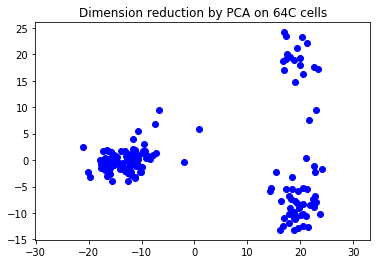

In [5]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(tmp_mat)
pm = pca.transform(tmp_mat)
plt.plot(pm[:,0],pm[:,1], 'bo')
plt.axis('equal'); plt.title('Dimension reduction by PCA on 64C cells')
plt.show()

In [6]:
ctyp_Q = {}
cnt = 0
for i in range(pm.shape[0]):
    if pm[i,0] >= 10:
        ctyp_Q[cind_Q_64C_all[i]] = "ICM"
        cnt += 1
    else:
        ctyp_Q[cind_Q_64C_all[i]] = "TE"
print(cnt, "ICM cells at 64C")

63 ICM cells at 64C


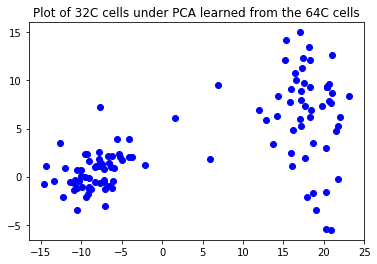

In [7]:
cind_Q_32C_all = []
for i in range(len(cname_Q)):
    tmp_sname,_ = cname_Q[i].split(' ')
    if tmp_sname == '32C': cind_Q_32C_all.append(i)
cind_Q_32C_all = np.asarray(cind_Q_32C_all, int)
mat_Q_normalized = mat_Q - mat_Q_64C_all_mean.reshape(1,-1)
tmp_mat = mat_Q_normalized[cind_Q_32C_all,:]
pm = pca.transform(tmp_mat)
plt.plot(pm[:,0],pm[:,1], 'bo')
plt.title('Plot of 32C cells under PCA learned from the 64C cells')
plt.show()

In [8]:
cnt = 0
for i in range(pm.shape[0]):
    if pm[i,0] >= 10:
        cnt += 1
        ctyp_Q[cind_Q_32C_all[i]] = "ICM"
    else:
        ctyp_Q[cind_Q_32C_all[i]] = "TE"
print(cnt, "ICM cells at 32C")

52 ICM cells at 32C


In [9]:
sname = '64C'; eid = 1; cind_Q_64C = []
for i in range(len(cname_Q)):
    name = cname_Q[i]
    tmp_sname, tmp_cname = name.split(' ');
    if tmp_sname == sname:
        tmp_eid,_ = tmp_cname.split('.')
        if int(tmp_eid) == eid: 
            if ctyp_Q[i] != 'TE':
                cind_Q_64C.append(i)
outfile = open('../input_data/Q_C64E'+str(eid)+'.txt','w')
outfile.write('CellName,CellID\n')
for i in range(len(cind_Q_64C)):
    outfile.write(cname_Q[cind_Q_64C[i]]+","+str(cind_Q_64C[i]))
    outfile.write('\n')
outfile.close()

# Process scRNAseq data (E4.5)

## First download the scRNA-seq data from GEO database with the accession code: GSE100597.

In [10]:
stage = 'E4.5'

In [11]:
df_G = pd.read_csv('./scData/GSE100597_count_table_QC_filtered.txt', sep="\t") # This is the downloaded scRNA-seq data.
cname_G = list( df_G.columns.values[1:] )
gname_G = list( df_G.values[:,0] )
mat_G = np.asarray( df_G.values[:,1:], float )
for i in range(len(gname_G)):
    if gname_G[i][:6] == 'Pou5f1':
        gname_G[i] = 'Oct4'

In [12]:
iembryo = 4
embryo = "embryo"+str(iembryo)
cind = []
for i in range(len(cname_G)):
    if cname_G[i][:4] == stage:
        _,_,_,tmp,_ = cname_G[i].split('_')
        if tmp == embryo:
            cind.append(i)
cind = np.asarray(cind)
outfile = open('../input_data/G_'+stage+'Em'+str(iembryo)+'.txt','w')
outfile.write('CellName,CellID\n')
for i in range(len(cind)):
    outfile.write(cname_G[cind[i]]+","+str(cind[i]))
    outfile.write('\n')
outfile.close()

# Mapping and trajectories between stages

In [13]:
from umap import UMAP
from sklearn.manifold import SpectralEmbedding, Isomap, TSNE, spectral_embedding
import networkx as nx
from scipy.optimize import linear_sum_assignment
import pickle
from scipy.stats import spearmanr
from scipy.spatial import distance_matrix

In [14]:
def graph_knn(pts, k = 10, cut = np.inf, draw = False):
    # Assymetric knn graph
    A_knn = kneighbors_graph(pts, n_neighbors=k, mode='connectivity')
    # Make it symetric
    A_knn_sym = ((A_knn + A_knn.T).astype(bool)).astype(int)
    # Apply the cutoff
    if not np.isinf(cut):
        A_rn = radius_neighbors_graph(pts, radius=cut, mode='connectivity')
        A_knn_sym = A_knn_sym.multiply(A_rn)
    # Plot the graph
    if draw:
        G = nx.from_scipy_sparse_matrix(A_knn_sym)
        pts_list = list(pts)
        n_node = len(pts_list)
        pos_dict = {i:pts_list[i] for i in range(n_node)}
        nx.draw_networkx(G, pos=pos_dict, with_labels=False, node_size=10, node_color='dimgrey', edge_color='darkgrey')
        plt.axis('equal'); plt.axis('off'); plt.show()

    return A_knn_sym

def knn(D, k, estimate_cutoff=True):
    A = np.zeros_like(D)
    for i in range(D.shape[0]):
        A[i,np.argsort(D[i,:])[1:k+1]] = 1.0
    A_sym = ((A+A.T).astype(bool)).astype(int)
    if estimate_cutoff:
        cut_est = np.sum(A_sym * D)/np.sum(A_sym)
        A_sym[np.where(D>cut_est)] = 0.0
    return A_sym

def compute_pairwise_scc(X1, X2):
    X1 = X1.argsort(axis=1).argsort(axis=1)
    X2 = X2.argsort(axis=1).argsort(axis=1)
    X1 = (X1-X1.mean(axis=1, keepdims=True))/X1.std(axis=1, keepdims=True)
    X2 = (X2-X2.mean(axis=1, keepdims=True))/X2.std(axis=1, keepdims=True)
    sccmat = np.empty([X1.shape[0], X2.shape[0]], float)
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            c = np.dot( X1[i,:], X2[j,:]) / float(X1.shape[1])
            sccmat[i,j] = c
    return sccmat

def preprocess_expression(X, min_pos=10, n_top=None, log_normalize=False, scale=False):
    X_bin = (X.astype(bool)).astype(float)
    print(X_bin.shape)
    cnt = np.sum(X_bin, axis=0)
    ind = np.where(cnt >= min_pos)[0]
    X = X[:,ind]

    if log_normalize:
        X = np.log(X+1.0)
    X_std = np.std(X, axis=0)
    X_ave = np.mean(X, axis=0)
    if scale:
        X_scaled = np.empty_like(X)
        for i in range(X.shape[1]):
            X_scaled[:,i] = ( X[:,i] - X_ave[i] ) / X_std[i]
        X = X_scaled
    if not n_top is None:
        fano = np.zeros([len(X_std)])
        for i in range(len(X_std)):
            if X_ave[i] > 0.0:
                fano[i] = X_ave[i] / X_std[i]
        ind = np.argsort(-fano)[:n_top]
        X = X[:,ind]
    print(X.shape)
    return X

In [15]:
df_G = pd.read_csv('./scData/GSE100597_count_table_QC_filtered.txt', sep="\t", index_col=0).T
df_Q = pd.read_csv('./scData/qPCR_original.csv', sep=',', index_col=0)

In [16]:
# Get the list of common genes across the datasets
cname_Q = list( df_Q.index )
gname_Q = list( df_Q.columns.values )
mat_Q = np.asarray( df_Q.values[:,:], float )
mat_Q = 28.0 - mat_Q; mat_Q[np.where(mat_Q < 0)[0]] = 0.0
# remove the two house keeping genes
tmp_ind = np.array([i for i in range(len(gname_Q)) if not gname_Q[i] in ["Actb","Gapdh"]],int)
mat_Q = mat_Q[:,tmp_ind]
gname_Q = [g for g in gname_Q if not g in ["Actb","Gapdh"]]

cname_G = list( df_G.index )
gname_G = list( df_G.columns.values )
mat_G = np.asarray( df_G.values, float )
mat_G = np.log(1+mat_G)

gind_G = []
gind_Q = []
for i in range(len(gname_Q)):
    for j in range(len(gname_G)):
        if gname_Q[i] == gname_G[j][:len(gname_Q[i])] and gname_G[j][len(gname_Q[i])] == '_':
            gind_Q.append(i)
            gind_G.append(j)
gind_Q = np.asarray(gind_Q)
gind_G = np.asarray(gind_G)
common_genes = [gname_Q[i] for i in gind_Q]
print("There are", len(common_genes), "in the two datasets.")

There are 40 in the two datasets.


In [17]:
# The cell id for E4.5 cells in scRNA-seq data
cind_G_E45 = []
for i in range(len(cname_G)):
    if cname_G[i][:4] == 'E4.5':
        cind_G_E45.append(i)
cind_G_E45 = np.asarray(cind_G_E45, int)

In [18]:
# The cell id for 32C and 64C cells
cind_Q_64C_ICM = []
for i in cind_Q_64C_all:
    if ctyp_Q[i] == "ICM":
        cind_Q_64C_ICM.append(i)
cind_Q_64C_ICM = np.asarray(cind_Q_64C_ICM, int)
cind_Q_32C_ICM = []
for i in cind_Q_32C_all:
    if ctyp_Q[i] == "ICM":
        cind_Q_32C_ICM.append(i)
cind_Q_32C_ICM = np.asarray(cind_Q_32C_ICM, int)
cind_Q_32C_64C_ICM = np.concatenate((cind_Q_32C_ICM, cind_Q_64C_ICM), axis=0)

In [19]:
# Gather some matrices for connection
mat_Q_32C_64C_ICM_allgene = mat_Q[cind_Q_32C_64C_ICM,:]
mat_Q_32C_64C_ICM_commongene = mat_Q[cind_Q_32C_64C_ICM,:][:,gind_Q]
mat_G_E45_allgene = mat_G[cind_G_E45,:]
mat_G_E45_commongene = mat_G[cind_G_E45,:][:,gind_G]
mat_total = np.concatenate((mat_Q_32C_64C_ICM_commongene, mat_G_E45_commongene), axis=0)
print(len(cind_Q_32C_ICM), len(cind_Q_64C_ICM), len(cind_G_E45))
nc_total = len(cind_Q_32C_ICM)+len(cind_Q_64C_ICM)+len(cind_G_E45)

52 63 105


In [20]:
# correlation within qPCR data
cor_Q = compute_pairwise_scc(mat_Q_32C_64C_ICM_allgene, mat_Q_32C_64C_ICM_allgene)
A_Q = knn(np.exp(-cor_Q), 5, estimate_cutoff=False)
D_Q = np.exp(-cor_Q)
D_Q = (D_Q-D_Q.min())/(D_Q.max()-D_Q.min())
print(np.sum(A_Q))

823


In [39]:
# correlation within scRNA-seq data
mat_G_E45_processed = preprocess_expression(mat_G_E45_allgene, min_pos=3, n_top=3000, log_normalize=False, scale=False)
mat_G_E45_pca = PCA(n_components=30, svd_solver='full').fit_transform(mat_G_E45_processed)
D_G = distance_matrix(mat_G_E45_pca, mat_G_E45_pca)
D_G = D_G/D_G.max()
A_G = knn(D_G, 5, estimate_cutoff=False)
print(np.sum(A_G))

(105, 24483)
(105, 3000)
830


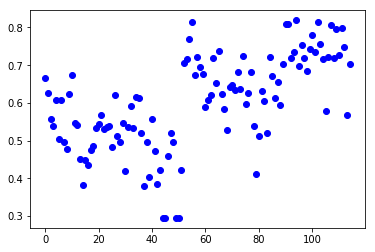

In [40]:
# correlation between qPCR and scRNA-seq data
cor_QG = compute_pairwise_scc(mat_Q_32C_64C_ICM_commongene, mat_G_E45_commongene)
D_QG = np.exp(-cor_QG)
D_QG = (D_QG-D_QG.min())/(D_QG.max()-D_QG.min())
plt.plot(cor_QG.max(axis=1), 'bo')

In [41]:
A_total = np.zeros([nc_total, nc_total])
A_total[:A_Q.shape[0], :A_Q.shape[0]] = A_Q[:,:]
A_total[A_Q.shape[0]:, A_Q.shape[0]:] = A_G[:,:]
for i in range(cor_QG.shape[0]):
    for j in range(cor_QG.shape[1]):
        if cor_QG[i,j] > 0.7:
            A_total[i,j+cor_QG.shape[0]] = 1.0

cname_total = []
for i in cind_Q_32C_ICM:
    cname_total.append(cname_Q[i])
for i in cind_Q_64C_ICM:
    cname_total.append(cname_Q[i])
for i in cind_G_E45:
    cname_total.append(cname_G[i])

D_total = np.zeros([nc_total, nc_total])
D_total[:A_Q.shape[0], :A_Q.shape[0]] = D_Q[:,:]
D_total[A_Q.shape[0]:, A_Q.shape[0]:] = D_G[:,:]
D_total[:A_Q.shape[0], A_Q.shape[0]:] = D_QG[:,:]
D_total[A_Q.shape[0]:, :A_Q.shape[0]] = D_QG.T[:,:]

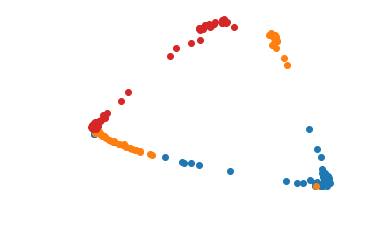

In [53]:
X = spectral_embedding(A_total, n_components=2)
plt.scatter(X[:52,0], X[:52,1], c="C0")
plt.scatter(X[52:115,0], X[52:115,1], c="C1")
plt.scatter(X[115:,0], X[115:,1], c="C3")
plt.axis("off")
plt.savefig("../result_analysis/figures/seq_traj.png", dpi=300)
os.system("convert -trim ../result_analysis/figures/seq_traj.png ../result_analysis/figures/seq_traj.png")
plt.show()

In [43]:
# Construct a graph for the entire trajectory
G = nx.Graph()
G.add_nodes_from(cname_total)
for i in range(A_total.shape[0]-1):
    for j in range(i+1,A_total.shape[0]):
        if A_total[i,j] == 1.0:
            G.add_edge(cname_total[i], cname_total[j], distance=D_total[i,j])

/home/cang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


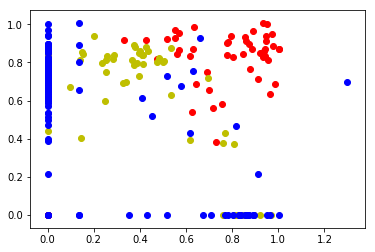

In [44]:
# Get a common normalized matrix for the cells
mat_total_normalized = np.empty_like(mat_total)
q = 0.99
for i in range(len(common_genes)):
    if np.quantile(mat_Q_32C_64C_ICM_commongene[:,i], q) == 0.0:
        tmp_Q = np.max(mat_Q_32C_64C_ICM_commongene[:,i])
    else:
        tmp_Q = np.quantile(mat_Q_32C_64C_ICM_commongene[:,i], q)
    if np.quantile(mat_G_E45_commongene[:,i], q) == 0.0:
        tmp_G = np.max(mat_G_E45_commongene[:,i])
    else:
        tmp_G = np.quantile(mat_G_E45_commongene[:,i], q)
    mat_total_normalized[:len(cind_Q_32C_64C_ICM),i] = mat_Q_32C_64C_ICM_commongene[:,i]/tmp_Q
    mat_total_normalized[len(cind_Q_32C_64C_ICM):,i] = mat_G_E45_commongene[:,i]/tmp_G
plt.scatter(mat_total_normalized[:52, common_genes.index("Nanog")], mat_total_normalized[:52, common_genes.index("Gata6")], c='r')
plt.scatter(mat_total_normalized[52:115, common_genes.index("Nanog")], mat_total_normalized[52:115, common_genes.index("Gata6")], c='y')
plt.scatter(mat_total_normalized[115:, common_genes.index("Nanog")], mat_total_normalized[115:, common_genes.index("Gata6")], c='b')
plt.show()

In [45]:
def generate_dev_map(name_st, name_ed, G, max_decendent=2, k=3):
    df_st = pd.read_csv("../input_data/"+name_st+".txt", sep=",")
    cname_st = list(df_st["CellName"])
    df_ed = pd.read_csv("../input_data/"+name_ed+".txt", sep=",")
    cname_ed = list(df_ed["CellName"])
    print("mapping", len(cname_st),"cells to", len(cname_ed), "cells")
    # Compute pairwise distance between cells using shortest path
    Dis = np.zeros([len(cname_st), len(cname_ed)], float)
    for i in range(Dis.shape[0]):
        for j in range(Dis.shape[1]):
            d = nx.shortest_path_length(G, cname_st[i], cname_ed[j], weight="distance")
            Dis[i,j] = d
    # Set up the cost for the ot problem
    cost = Dis
    for i in range(max_decendent-1):
        cost = np.concatenate((cost, Dis), axis=0)
    cost = np.transpose(cost)
    # Get the optimal pairing by linear_sum assignment
    # (allowing at most 1 to max_decendent mapping)
    row_ind, col_ind = linear_sum_assignment(cost)
    # Output the mapping of cells
    outfile = open("../input_data/devmap_"+name_st+"-"+name_ed+".txt", "w")
    # Output the trajectory of key genes
    outfile1 = open("../input_data/devmappath_"+name_st+"-"+name_ed+".pkl", "wb")
    
    gene_traj_list = []
    pair_list = []
    # Assign the ones that got paired
    for i in range(len(row_ind)):
        start = col_ind[i]%len(cname_st); end = row_ind[i]
        path = nx.shortest_path(G, cname_st[start], cname_ed[end], weight="distance")
        pair_list.append([col_ind[i]%len(cname_st), row_ind[i]])
        gene_traj = np.empty([mat_total_normalized.shape[1],0], float)
        for j in path:
            tmp_gene = np.zeros([mat_total_normalized.shape[1],1], float)
            if j == path[0] or j == path[-1]:
                tmp_gene[:,0] = mat_total_normalized[cname_total.index(j),:]
            else:
                tmp_knn = sorted(G[j].items(), key=lambda e: e[1]["distance"], reverse=False)[:k]
                cnt = 0.0
                for nb in tmp_knn:
                    tmp_gene[:,0] = tmp_gene[:,0] + mat_total_normalized[cname_total.index(nb[0]),:]
                    cnt += 1.0
                tmp_gene[:,0] = tmp_gene[:,0] / cnt
            gene_traj = np.concatenate((gene_traj, tmp_gene), axis=1)
        gene_traj_list.append(gene_traj)
    for i in range(len(cname_ed)):
        if not i in row_ind:
            pair_list.append([-1,i])
            gene_traj_list.append(mat_total_normalized[cname_total.index(cname_ed[i]),:].reshape(-1,1))
    for i in range(len(pair_list)):
        if pair_list[i][0] == -1:
            outfile.write("NoCell,"+cname_ed[pair_list[i][1]]+"\n")
        else:
            outfile.write(cname_st[pair_list[i][0]]+","+cname_ed[pair_list[i][1]]+"\n")
    pickle.dump(gene_traj_list, outfile1)

In [46]:
generate_dev_map("Q_C64E1", "G_E4.5Em4", G)

mapping 17 cells to 34 cells


[ 3 16 25 28]


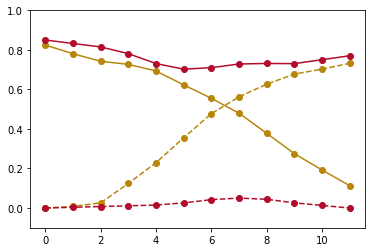

In [47]:
ninterval = 11
nc = 34

infile = open("../input_data/devmappath_Q_C64E1-G_E4.5Em4.pkl", "rb")
seq_path = pickle.load(infile)
common_genes = list( np.loadtxt("../input_data/common_genes.txt", dtype=str) )
seq_path_interp = np.empty([ninterval+1, nc, len(common_genes)])
x = np.arange(ninterval+1)/float(ninterval)
for ig in range(len(common_genes)):
    for ic in range(nc):
        tmp_gene = seq_path[ic][ig,:]
        seq_path_interp[:,ic, ig] = np.interp(x, np.arange(len(tmp_gene))/(len(tmp_gene)-1), tmp_gene)
NG_start = seq_path_interp[0,:,np.array([common_genes.index("Nanog"), common_genes.index("Gata6")], int)].T
NG_end = seq_path_interp[-1,:,np.array([common_genes.index("Nanog"), common_genes.index("Gata6")], int)].T

ind_start_epi = np.where(NG_start[:,0] > NG_start[:,1])[0]
ind_end_pe = np.where(NG_end[:,0] < NG_end[:,1])[0]
ind_end_epi = np.where(NG_end[:,0] > NG_end[:,1])[0]

ind_cells_epi_to_pe = np.intersect1d(ind_end_pe, ind_start_epi)
ind_cells_other = np.array([i for i in range(34) if not i in ind_cells_epi_to_pe], int)

plt.plot(np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Nanog")], axis=1), '-o', color="darkgoldenrod")
plt.plot(np.mean(seq_path_interp[:,ind_cells_epi_to_pe,common_genes.index("Gata6")], axis=1), '--o', color="darkgoldenrod")
plt.plot(np.mean(seq_path_interp[:,ind_end_epi,common_genes.index("Nanog")], axis=1), '-o', color=(178/255,11/255,43/255))
plt.plot(np.mean(seq_path_interp[:,ind_end_epi,common_genes.index("Gata6")], axis=1), '--o', color=(178/255,11/255,43/255))
plt.ylim([-0.1,1])

print(ind_cells_epi_to_pe)